In [16]:
import numpy as np
import pandas as pd
from river.datasets import synth
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing
from river import drift
from river import datasets
import pickle
import matplotlib.pyplot as plt

In [17]:
# Function to return samples with a rolling average mean window
def moving_average(datastream, window_size):

    datastream_series = pd.Series(datastream)
    windows = datastream_series.rolling(window_size)
    moving_averages = windows.mean()

    return moving_averages.tolist()[window_size - 1:]

#### Sliding window 

In [18]:
# Create mini-batch of features and labels
from sklearn.metrics import accuracy_score

labels = list()
features = list()
predictions = list()
def create_mini_batch(feature, label, prediction, batch_size=5):

    labels.append(label)
    features.append(feature)
    predictions.append(int(prediction))
    
    label_window = pd.Series(labels)[-batch_size:]
    feature_window = pd.DataFrame(features)[-batch_size:]
    pred_window = pd.Series(predictions)[-batch_size:]
    
    accuracy = accuracy_score(label_window, pred_window)
    
    return feature_window, label_window, accuracy

In [19]:
# Load dataset
dataset = synth.Agrawal(
     classification_function=0,
     seed=42
)

# Load pickled model
LogRegmodel1 = pickle.load(open('/home/jaydeep/book_ML_drifts/chapter_5/saved_models/river_model.pkl', 'rb'))

# Initialise metric
metric = metrics.Accuracy()

# buffers to store data stream for re-trainig model
# feature_buffer = list()
# label_buffer = list()
accuracy_buffer_1 = list()

# batch size
batch_size = 10
window_size = 2

for i,data in enumerate(dataset.take(1000),1):
    # data[0] - features, data[1] - label
    y_pred = LogRegmodel1.predict_one(data[0])
    metric = metric.update(data[1],y_pred)
    feature_buffer,label_buffer, accuracy = create_mini_batch(data[0],data[1],y_pred,window_size*batch_size)
    if i%batch_size==0:
        accuracy_buffer_1.append(accuracy)
        print(feature_buffer.iloc[:,:2])
        print(f'Training model with sliding window')
        LogRegmodel1.learn_many(feature_buffer,label_buffer)
        print(LogRegmodel1)

print(metric)

          salary    commission
0   68690.215450  81303.572981
1   98144.951527      0.000000
2  148987.502708      0.000000
3   26066.536218  83031.663913
4   98980.830747      0.000000
5   70104.145330  11197.468917
6  138211.652270      0.000000
7   93801.042617      0.000000
8  139843.650553      0.000000
9   96277.651536      0.000000
Training model with sliding window
StandardScaler | LogisticRegression
           salary    commission
0    68690.215450  81303.572981
1    98144.951527      0.000000
2   148987.502708      0.000000
3    26066.536218  83031.663913
4    98980.830747      0.000000
5    70104.145330  11197.468917
6   138211.652270      0.000000
7    93801.042617      0.000000
8   139843.650553      0.000000
9    96277.651536      0.000000
10  148295.301758      0.000000
11  112474.453857      0.000000
12  101028.756488      0.000000
13   96868.712402      0.000000
14  118902.056320      0.000000
15   93225.824357      0.000000
16   40958.767343  79727.323926
17   35871.4

In [20]:
# Overall Accuracy
print(metric)

Accuracy: 53.10%


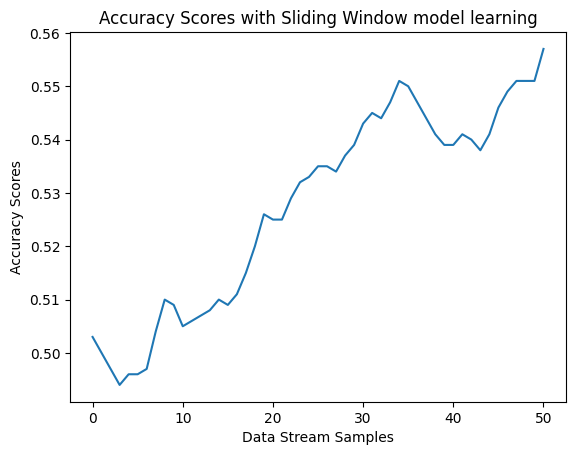

In [21]:
def plot():
    acc_scores_1_moving_avg = moving_average(accuracy_buffer_1,50)
    plt.plot(acc_scores_1_moving_avg)
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores with Sliding Window model learning')
    plt.show()
plot()

#### Landmark window

In [22]:
# Load dataset
dataset = synth.Agrawal(
     classification_function=0,
     seed=42
)

# Load pickled model
LogRegmodel2 = pickle.load(open('/home/jaydeep/book_ML_drifts/chapter_5/saved_models/river_model.pkl', 'rb'))

# Initialise metric
metric = metrics.Accuracy()

# buffers to store data stream for re-trainig model
# feature_buffer = list()
# label_buffer = list()
accuracy_buffer_2 = list()

# batch size
batch_size = 10
window_size = 2

for i,data in enumerate(dataset.take(1000),1):
    # data[0] - features, data[1] - label
    y_pred = LogRegmodel2.predict_one(data[0])
    metric = metric.update(data[1],y_pred)
    feature_buffer,label_buffer, accuracy = create_mini_batch(data[0],data[1],y_pred,window_size*batch_size)
    if i%batch_size==0 and i%(window_size*batch_size)==0:
        # if i%(window_size*batch_size)==0:
            accuracy_buffer_2.append(accuracy)
            print(feature_buffer.iloc[:,:2])
            print(f'Training model with landmark window')
            LogRegmodel2.learn_many(feature_buffer,label_buffer)


             salary    commission
1000   68690.215450  81303.572981
1001   98144.951527      0.000000
1002  148987.502708      0.000000
1003   26066.536218  83031.663913
1004   98980.830747      0.000000
1005   70104.145330  11197.468917
1006  138211.652270      0.000000
1007   93801.042617      0.000000
1008  139843.650553      0.000000
1009   96277.651536      0.000000
1010  148295.301758      0.000000
1011  112474.453857      0.000000
1012  101028.756488      0.000000
1013   96868.712402      0.000000
1014  118902.056320      0.000000
1015   93225.824357      0.000000
1016   40958.767343  79727.323926
1017   35871.434111  36722.337856
1018   74263.430409  26658.085785
1019   92553.260262      0.000000
Training model with landmark window
             salary    commission
1020   59114.180276  31363.037078
1021   64859.262243  57576.350853
1022   68055.079288  28161.995371
1023  123784.866248      0.000000
1024  112449.439217      0.000000
1025  141774.898536      0.000000
1026  105797

In [23]:
print(metric)

Accuracy: 53.50%


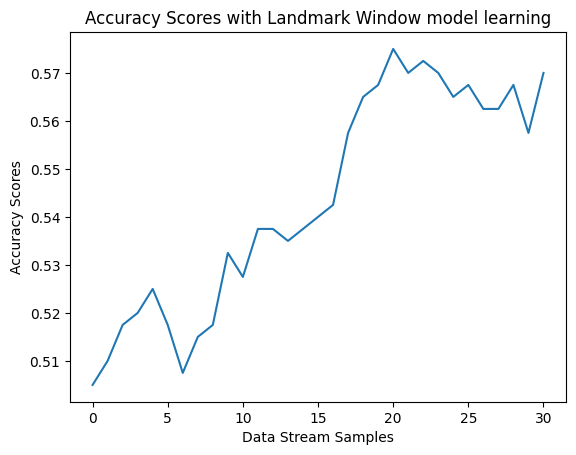

In [24]:
def plot():
    acc_scores_2_moving_avg = moving_average(accuracy_buffer_2,20)
    plt.plot(acc_scores_2_moving_avg)
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores with Landmark Window model learning')
    plt.show()
plot()